In [31]:
import numpy as np
import os
import matplotlib.pyplot as plt 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pathlib import Path
import tensorflow
import pandas as pd
from tensorflow.keras.preprocessing import image

In [32]:
def count_images_in_folders(base_dir):
    categories = os.listdir(base_dir)
    image_counts = {category: len(os.listdir(os.path.join(base_dir, category))) for category in categories}
    return image_counts

train_dir = "dataset/Test_Cars"
image_counts = count_images_in_folders(train_dir)

print("Số lượng ảnh trong từng lớp:")
for category, count in image_counts.items():
    print(f"{category}: {count} ảnh")


Số lượng ảnh trong từng lớp:
hyundai: 67 ảnh
lexus: 67 ảnh
mazda: 67 ảnh
mercedes: 67 ảnh
opel: 67 ảnh
skoda: 67 ảnh
toyota: 67 ảnh
volkswagen: 67 ảnh


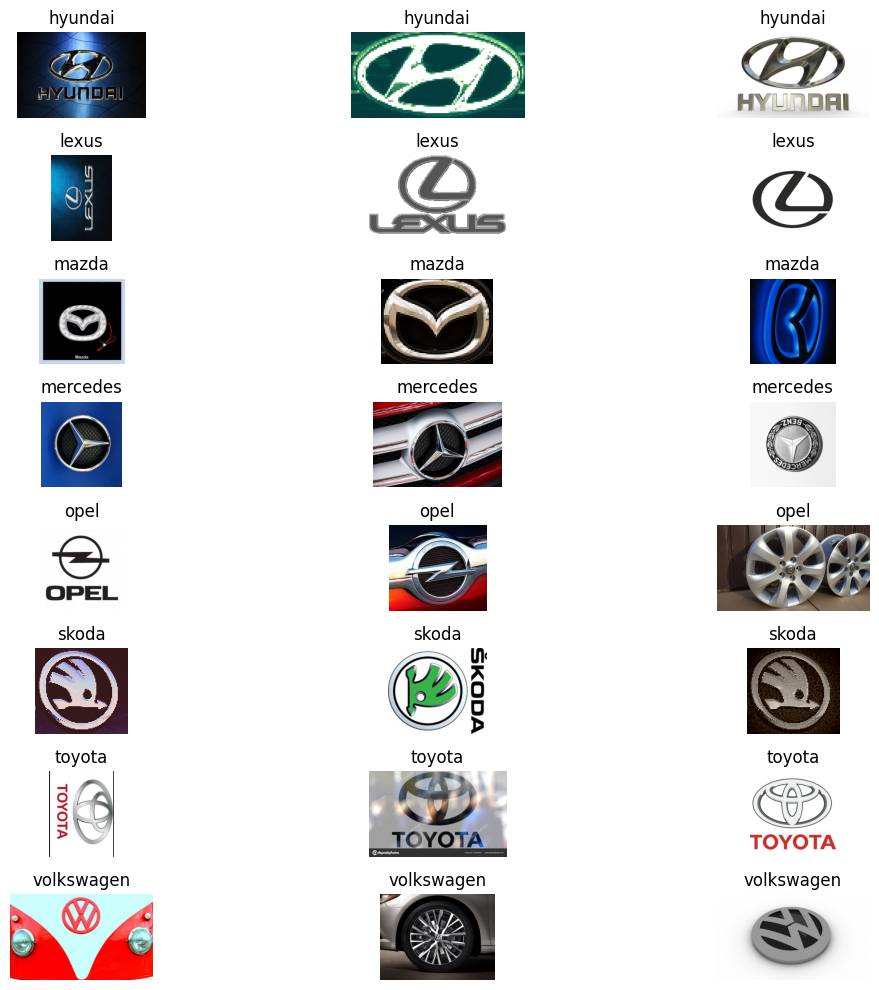

In [33]:
import matplotlib.pyplot as plt
import cv2
import random

def show_sample_images(base_dir, categories, num_images=3):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(12, 10))

    for i, category in enumerate(categories):
        image_files = os.listdir(os.path.join(base_dir, category))
        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        for j, img_file in enumerate(selected_images):
            img_path = os.path.join(base_dir, category, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB để hiển thị đúng màu

            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(category)

    plt.tight_layout()
    plt.show()

categories = list(image_counts.keys())
show_sample_images(train_dir, categories)


In [34]:
def check_image_sizes(base_dir, categories):
    sizes = []
    for category in categories:
        image_files = os.listdir(os.path.join(base_dir, category))
        img_path = os.path.join(base_dir, category, image_files[0])  # Lấy một ảnh mẫu
        img = cv2.imread(img_path)
        sizes.append(img.shape)

    unique_sizes = np.unique(sizes, axis=0)
    print("Các kích thước ảnh trong dataset:", unique_sizes)

check_image_sizes(train_dir, categories)


Các kích thước ảnh trong dataset: [[ 114  150    3]
 [ 117  121    3]
 [ 156  208    3]
 [ 209  280    3]
 [ 540  960    3]
 [ 900  900    3]
 [1024 1029    3]
 [1152 1600    3]]


In [35]:
all_images = []
all_labels = []

for category in categories:
    img_files = os.listdir(os.path.join(train_dir, category))
    all_images.extend([os.path.join(train_dir, category, img) for img in img_files])
    all_labels.extend([category] * len(img_files))

train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

print(f"Tổng số ảnh: {len(all_images)}")
print(f"Số ảnh train: {len(train_images)}")
print(f"Số ảnh test: {len(test_images)}")

Tổng số ảnh: 536
Số ảnh train: 428
Số ảnh test: 108


In [36]:
img_size = (224, 224)
batch_size = 32

# Data Augmentation & Rescale
datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu từ list train/test
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": train_images, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": test_images, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 428 validated image filenames belonging to 8 classes.
Found 108 validated image filenames belonging to 8 classes.


In [41]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Giữ nguyên trọng số pre-trained

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(8, activation='softmax')(x)  # 8 lớp tương ứng với số class

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

model.fit(train_generator, validation_data=test_generator, epochs=30)



Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 748ms/step - accuracy: 0.3421 - loss: 1.9486 - val_accuracy: 0.6759 - val_loss: 0.9963
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 625ms/step - accuracy: 0.8095 - loss: 0.6114 - val_accuracy: 0.7407 - val_loss: 0.8808
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 626ms/step - accuracy: 0.9292 - loss: 0.2951 - val_accuracy: 0.7593 - val_loss: 0.7035
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 644ms/step - accuracy: 0.9864 - loss: 0.1514 - val_accuracy: 0.7963 - val_loss: 0.6549
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step - accuracy: 0.9997 - loss: 0.0843 - val_accuracy: 0.8148 - val_loss: 0.6569
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 639ms/step - accuracy: 1.0000 - loss: 0.0624 - val_accuracy: 0.7870 - val_loss: 0.6823
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 612ms/step - accuracy: 1.0000 - loss: 0.0277 - val_accuracy: 0.8056 - val_loss: 0.6734
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 615ms/step - accuracy: 1.0000 - loss: 0.0285 - val_accuracy: 0

In [43]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.7837 - loss: 0.7862
Test Loss: 0.75
Test Accuracy: 80.56%
